# Summary

This document contains all the steps relevant to feature engineering. Now that the data is clean, I will comb through Trump's tweets to look for patterns that might improve predictability. 

### Import Packages, Load Data

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
# For removing and counting stopwords
from nltk.corpus import stopwords
# For lemmatization 
from textblob import TextBlob
from textblob import Word
# For idf and tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('~/Documents/GitHub/Trump-Twitter-Predictions/Data/abt.csv', encoding = 'ISO-8859-1')
df.head()

,source,text,retweet_count,favorite_count,Followers,Follower_Change,Num_Tweets,Year,Month,Week,Day,Hour,Holiday
0,Twitter for iPhone,Judge Kavanaugh showed America exactly why I n...,85502,320158,54672474.0,21128.0,12,2018,9,39,27,22,0
1,Twitter for iPhone,https://t.co/9o5gZlJiTd,17391,77145,54651346.0,20751.0,13,2018,9,39,26,23,0
2,Twitter for iPhone,Join me this Saturday in Wheeling West Virgini...,14484,52957,54651346.0,20751.0,13,2018,9,39,26,20,0
3,Twitter for iPhone,Congressman Lee Zeldin is doing a fantastic jo...,14949,65494,54651346.0,20751.0,13,2018,9,39,26,17,0
4,Twitter for iPhone,China is actually placing propaganda ads in th...,19236,58671,54651346.0,20751.0,13,2018,9,39,26,17,0


# Basic Feature Extraction From Text

I want to extract features such as the number of words, and the average length of the words Trump uses. However, this means that I don't want there to be urls in the tweets I'm deriving these counts for, so I need to make a new column that is free of urls. 

### Remove URLS

In [3]:
df['trump_text'] = df.text.str.replace(r'http\S+', '')

In [4]:
df['Word_Count'] = df.trump_text.apply(lambda x: len(str(x).split(' ')))
df[['Word_Count', 'trump_text']].head()

,Word_Count,trump_text
0,42,Judge Kavanaugh showed America exactly why I n...
1,1,
2,13,Join me this Saturday in Wheeling West Virgini...
3,34,Congressman Lee Zeldin is doing a fantastic jo...
4,41,China is actually placing propaganda ads in th...


### Indicator of URLs

It may be helpful to know whether or not a tweet has a url. We can create an indicator variable for it. 

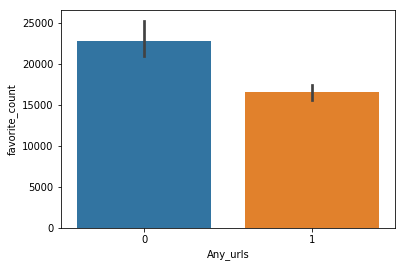

In [5]:
# Create column with all 0s
df['Any_urls'] = 0
# Find indices with 0s
indices_with_urls = df.text.str.extractall(r'(http\S+)').index.get_level_values(0)
# Make those indices 1
df.iloc[indices_with_urls, np.where(df.columns.isin(['Any_urls']))[0]] = 1

# Visualize median per group 
sns.barplot(x = df.Any_urls, y = df.favorite_count, estimator=np.median)

### Number of Characters

In [6]:
df['Character_Count'] = df.trump_text.str.len()
df[['Character_Count', 'trump_text']].head()

,Character_Count,trump_text
0,264,Judge Kavanaugh showed America exactly why I n...
1,0,
2,67,Join me this Saturday in Wheeling West Virgini...
3,182,Congressman Lee Zeldin is doing a fantastic jo...
4,225,China is actually placing propaganda ads in th...


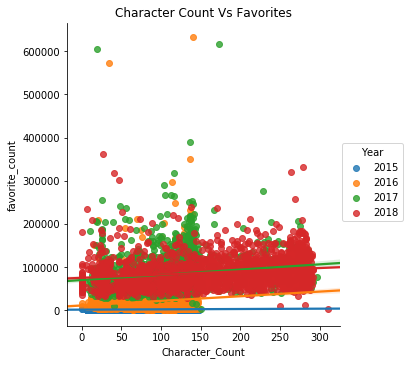

Correlation is: 0.41246254440294994


In [7]:
sns.lmplot(y = "favorite_count", x = "Character_Count", hue = 'Year', data = df)
plt.title('Character Count Vs Favorites')
plt.show()
print('Correlation is:', df[['favorite_count', 'Character_Count']].corr().iloc[1,0])

### Average Word Length

In [8]:
# Define function to generate avg_length
def avg_word_length(tweet): 
    words = tweet.split()
    if len(words) > 0:
        return(sum(len(word) for word in words) / len(words))
    else: 
        return(0)

df['avg_word_len'] = df.trump_text.apply(avg_word_length)

df[['avg_word_len', 'trump_text']].head()

,avg_word_len,trump_text
0,5.309524,Judge Kavanaugh showed America exactly why I n...
1,0.000000,
2,5.000000,Join me this Saturday in Wheeling West Virgini...
3,4.382353,Congressman Lee Zeldin is doing a fantastic jo...
4,4.625000,China is actually placing propaganda ads in th...


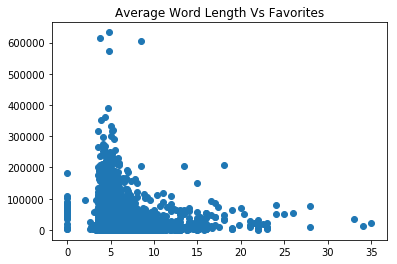

Correlation is: -0.19636472418194117


In [9]:
plt.scatter(y = "favorite_count", x = "avg_word_len", data = df)
plt.title('Average Word Length Vs Favorites')
plt.show()

print('Correlation is:', df[['favorite_count', 'avg_word_len']].corr().iloc[1,0])

### Number of Stopwords

In [10]:
swords = stopwords.words('english')
df['Num_Stopwords'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.lower() in swords]))
df[['Num_Stopwords', 'trump_text']].head()

,Num_Stopwords,trump_text
0,16,Judge Kavanaugh showed America exactly why I n...
1,0,
2,4,Join me this Saturday in Wheeling West Virgini...
3,18,Congressman Lee Zeldin is doing a fantastic jo...
4,18,China is actually placing propaganda ads in th...


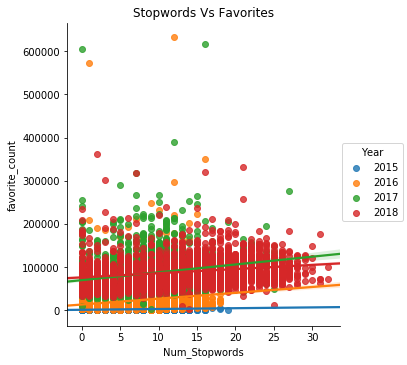

Correlation is: 0.43141227526451176


In [11]:
sns.lmplot(y = "favorite_count", x = "Num_Stopwords", hue = 'Year', data = df)
plt.title('Stopwords Vs Favorites')
plt.show()

print('Correlation is:', df[['favorite_count', 'Num_Stopwords']].corr().iloc[1,0])

### Number and Presence of Hashtags 

It may be helpful to know how many hashtags are in given tweets. Trump doesn't tweet too often with hashtags, so it might be more helpful to have an indicator variable simply demonstrating whether or not there are hashtags. 

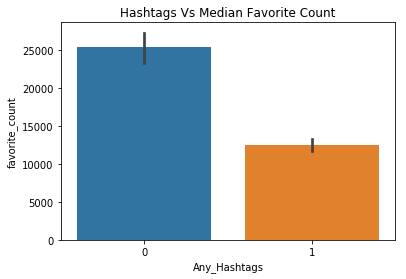

In [12]:
# Presence 
indices_with_hashtags = df.trump_text.str.extractall(r'(#)', re.IGNORECASE).index.get_level_values(0)
# Create an indicator variable, set all to 0 
df['Any_Hashtags'] = 0
# Set indices_with_hashtags to 1
df.iloc[indices_with_hashtags, np.where(df.columns.isin(['Any_Hashtags']))[0]] = 1

# Number
df['Num_Hashtags'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

# Visualize presence 
sns.barplot(x = df.Any_Hashtags, y = df.favorite_count, estimator=np.median)
plt.title('Hashtags Vs Median Favorite Count')
plt.show()

We can even see that when Trump does use hashtags, he typically uses 1. 

In [13]:
print('The mode hashtags when used is', df.Num_Hashtags[df.Num_Hashtags>0].mode().values)

The mode hashtags when used is [1]


### Number and Presence of Mentions

Again, we'll take a look at when (and how often) he uses mentions. 

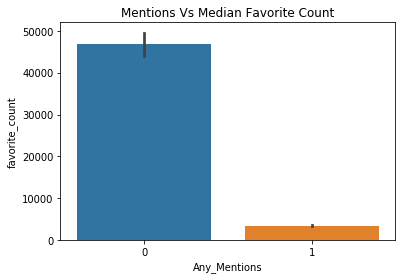

In [14]:
# Presence
indices_with_mentions = df.trump_text.str.extractall(r'(@)', re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Mentions'] = 0
# Set proper indices to 1
df.iloc[indices_with_mentions, np.where(df.columns.isin(['Any_Mentions']))[0]] = 1

# Number
df['Num_Mentions'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

# Visualize mentions
sns.barplot(x = df.Any_Mentions, y = df.favorite_count, estimator=np.median)
plt.title('Mentions Vs Median Favorite Count')
plt.show()

### Uppercase

Trump will often use his caps lock generously, either for entire tweets, or for emphasis purposes. I'll make an indicator variable for if a tweet is entirely in caps. This might be overkill, but I'd rather start off with more variables than fewer. 

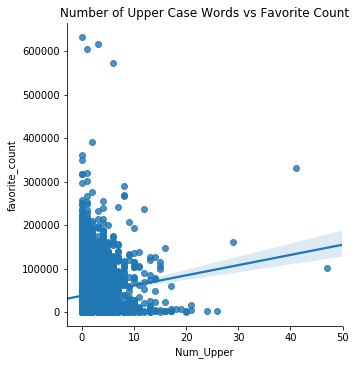

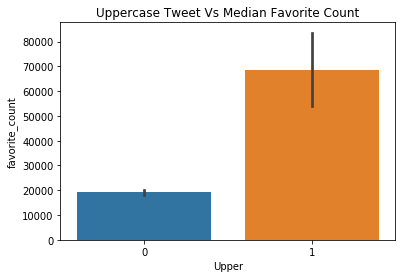

In [15]:
# Number a
df['Num_Upper'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.isupper()]))

# Presence
df['Upper'] = df.trump_text.str.isupper().astype(int)

# Visualize number of upper
sns.lmplot(y='favorite_count', x = 'Num_Upper', data = df)
plt.title('Number of Upper Case Words vs Favorite Count')
plt.show()

# Visualize presence by median per group 
sns.barplot(x=df.Upper, y = df.favorite_count, estimator=np.median)
plt.title('Uppercase Tweet Vs Median Favorite Count')
plt.show()

### Number of Exclamations 

Trump is an excitable guy. Tracking the number of exclamation marks per tweet might become useful. 

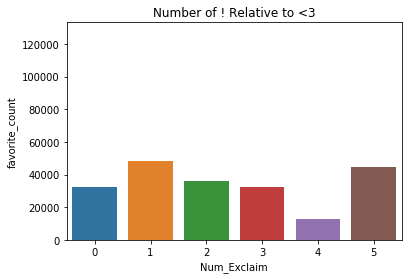

In [16]:
# Create column
df['Num_Exclaim'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.endswith('!')]))
# Visualize
sns.barplot(y = 'favorite_count', x = 'Num_Exclaim', data = df, errwidth=False)
plt.title('Number of ! Relative to <3')
plt.show()

### The Clintons 

Any mention of Hillary, or the Clintons. 

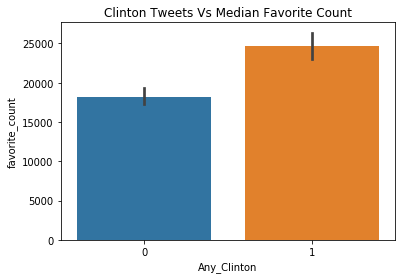

In [17]:
indices_with_clintons = df.trump_text.str.extractall(r'(hillary)|(hillary clinton)|(clinton)|(clintons)|(bill clinton)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Clinton'] = 0
# Set proper indices to 1
df.iloc[indices_with_clintons, np.where(df.columns.isin(['Any_Clinton']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Clinton, y = df.favorite_count, estimator = np.median)
plt.title('Clinton Tweets Vs Median Favorite Count')
plt.show()

### Obama

Any mention of Obama

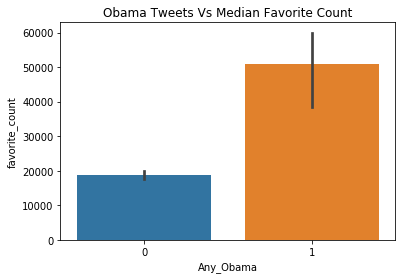

In [18]:
indices_with_obama = df.trump_text.str.extractall(r'(obama)|(barrack)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Obama'] = 0
# Set proper indices to 1
df.iloc[indices_with_obama, np.where(df.columns.isin(['Any_Obama']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Obama, y = df.favorite_count, estimator = np.median)
plt.title('Obama Tweets Vs Median Favorite Count')
plt.show()

### MAGA 

Any form of MAGA. 

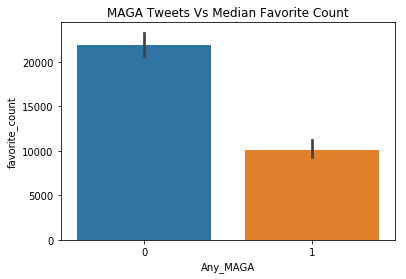

In [19]:
indices_with_maga = df.trump_text.str.extractall(r'(MAKE AMERICA GREAT AGAIN)|(MAGA)|(#MAKEAMERICAGREATAGAIN)|(#MAGA)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_MAGA'] = 0
# Set proper indices to 1
df.iloc[indices_with_maga, np.where(df.columns.isin(['Any_MAGA']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_MAGA, y = df.favorite_count, estimator = np.median)
plt.title('MAGA Tweets Vs Median Favorite Count')
plt.show()

### Sad/Bad

Any use of Sad or Bad

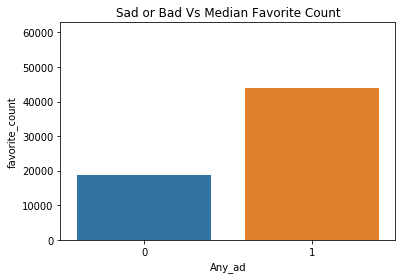

In [20]:
indices_with_ad = df.trump_text.str.extractall(r'(sad)|(bad)|(sad!)|(bad!)|(sad.)|(bad.)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_ad'] = 0
# Set proper indices to 1
df.iloc[indices_with_ad, np.where(df.columns.isin(['Any_ad']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_ad, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Sad or Bad Vs Median Favorite Count')
plt.show()

### Party Lines

Tweets about Democrats and Republicans. 

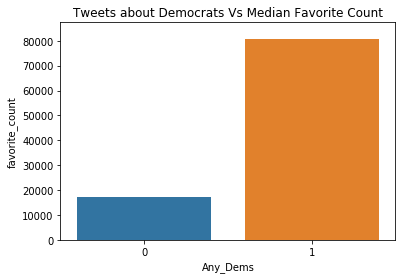

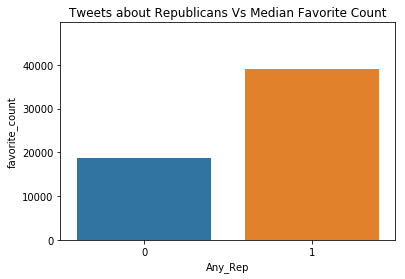

In [21]:
# Democrats
indices_with_dems = df.trump_text.str.extractall(r'(democrat)|(democratic)|(democrats)|(dems)|(dem)|(dnc)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Dems'] = 0
# Set proper indices to 1
df.iloc[indices_with_dems, np.where(df.columns.isin(['Any_Dems']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Dems, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets about Democrats Vs Median Favorite Count')
plt.show()

# Republicans
indices_with_reps = df.trump_text.str.extractall(r'(republican)|(rep)|(gop)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Rep'] = 0
# Set proper indices to 1
df.iloc[indices_with_reps, np.where(df.columns.isin(['Any_Rep']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Rep, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets about Republicans Vs Median Favorite Count')
plt.show()

# Preprocessing 

In order to conduct more advanced natural language processing techniques, I need to clean the text data a bit. This includes making all words lowercase, removing punctuation, stopwords, most commonly occurring words, and words that occur only once. Then I proceed to lemmatize the tweets, which essentially reduces words to their root forms. 

In [22]:
# Lowercase
df.trump_text = df.trump_text.str.lower()

# Remove punctuation
df.trump_text = df.trump_text.str.replace(pat = '[^\w\s]', repl = '')

# Remove stopwords
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in swords]))

# Remove most commonly occuring words 
freq_words = list(pd.Series(' '.join(df['trump_text']).split()).value_counts()[:10].index)
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in freq_words]))

# Remove all words that were only used once 
infreq_words = pd.Series(' '.join(df['trump_text']).split()).value_counts()
infreq_words = infreq_words[infreq_words.values == 1]
infreq_words = list(infreq_words.index)
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in infreq_words]))

# Lemmatize
df.trump_text = df.trump_text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Algorithmic Text Processing

Here I will employ common algorithms to extract other features from the text.

### Term Frequency Rate (TF)

The term frequency rate for any given word is the number of times that word appears in a tweet divided by the number of words in the tweet. I will average the term frequency rate for all words per tweet.

In [23]:
# Function to find average term frequency rate per tweet
def avg_tf_rate(tweet):
    # For empty tweets (tweets that were likely just urls), mean tf = 0
    if len(tweet) == 0:
        return(0)
    # For actual tweets, calculate it out 
    else: 
        return(np.mean(pd.value_counts(tweet.split(' '))/len(tweet)))

# Create tf column 
df['tf'] = df.trump_text.apply(lambda x: avg_tf_rate(x))

### Inverse Document Frequency (IDF)

IDF of a word is defined as the log of the ratio of the total number of rows to the number of rows in which that word is present. I will average the IDF for all words per tweet. Higher IDF indicates more rarely used words. 

This will require the use of sklearn's Tfidvectorizer function. Since I'm finding the idf for every word, I'll create a dataframe that includes 

In [25]:
# Create tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1))
# Fit the vocabulary 
idf_fit = vectorizer.fit(df.trump_text)
# Use the fit to find idf per phrase - save into a dataframe 
idf_df = pd.DataFrame({'Phrase': idf_fit.get_feature_names(), 'IDF': idf_fit.idf_})

In [26]:
def avg_idf_rate(tweet):
    # Tokenize the tweet
    tokenized_tweet = tweet.split(' ')
    # Find the idf per word using the idf_df 
    idf = idf_df[idf_df.Phrase.isin(tokenized_tweet)].IDF.values
    # Safeguard against empty lists - that means idf = 0
    if len(idf) == 0:
        return(0)
    else: 
        # Otherwise, return the average 
        return(np.mean(idf))
    
df['idf'] = df.trump_text.apply(lambda x: avg_idf_rate(x))

### TF-IDF

The TF-IDF of a word is simply the TF multiplied by the IDF. 

In [27]:
# use the idf_fit to find tf_idf per phrase 
tfidf_array = idf_fit.transform(df.trump_text).toarray()

In [28]:
# For every row in df
tfidf_list = []
for i in range(len(df)):
    if tfidf_array[i][tfidf_array[i]>0].sum() > 0: 
        tfidf_list.append(tfidf_array[i][tfidf_array[i]>0].mean())
    else: 
        tfidf_list.append(0)
        
# Create column
df['tfidf'] = tfidf_list